# Goals: 
1) How to make predictions using estimated linear regression models.
2) How to evaluate the predictive performance of regression models.

In [15]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse


import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [4]:
non_numeric_columns = house_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [5]:
house_df_dummified = pd.get_dummies(house_df, drop_first=True, columns=['salecondition'], prefix='salecondition')

In [6]:
house_df_dummified = pd.get_dummies(house_df_dummified, drop_first=True, columns=['mszoning'], prefix='mszoning')

In [7]:
house_df_dummified.columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'woo

In [8]:
df_with_dummies = pd.get_dummies(house_df, prefix_sep='salecondition', columns=['salecondition'])

## Dummy Variables 'mszoning' and 'salecondition'

In [9]:
columns_to_fit = [x for x in house_df_dummified.columns if 'mszoning' in x or 'salecondition' in x]

# HOUSE MODEL

In [13]:
# Y is the target variable, in other words what are trying to predict.
Y = house_df_dummified['saleprice']

# X is the feature set we are using to predict the house prices
X = house_df_dummified[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf'] + columns_to_fit]

## Train Data Set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Next, we use one of our previous models, but this time we train it using only the training set.

We will later predict on X_test and use different evaluation metrics to see how closely the predictions are to y_test.

In [17]:
X_train.head()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
151,5,969,2,440,969,0,0,0,1,0,0,0,1,0
262,8,2574,3,868,1482,0,0,0,0,1,0,0,1,0
1037,8,2263,2,905,1055,0,0,0,1,0,0,0,1,0
1183,5,1130,2,720,1120,0,0,0,1,0,0,0,1,0
933,7,1500,2,570,1500,0,0,0,1,0,0,0,1,0


In [18]:
X_train = sm.add_constant(X_train)

In [19]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     283.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:38:42   Log-Likelihood:                -13955.
No. Observations:                1168   AIC:                         2.794e+04
Df Residuals:                    1153   BIC:                         2.802e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.104e+

### Predictions for Model 1
It's time to get the predictions! In statsmodels, we make predictions by calling the predict() function as the following:

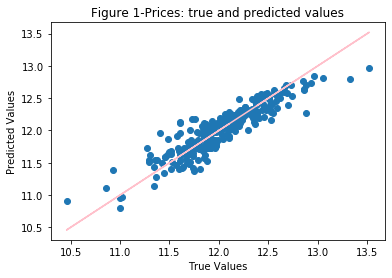

Mean absolute error of the prediction is: 0.1255263492080381
Mean squared error of the prediction is: 0.028061234942725548
Root mean squared error of the prediction is: 0.16751487976512877
Mean absolute percentage error of the prediction is: 1.048180295543415


In [25]:
# We add constant to the model as it's a best practice to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="pink")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Figure 1-Prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Another House Model Using Interaction

In [21]:
house_df_dummified['totalsf'] = house_df_dummified['totalbsmtsf'] + house_df_dummified['firstflrsf'] + house_df_dummified['secondflrsf']

house_df_dummified['int_over_sf'] = house_df_dummified['totalsf'] * house_df_dummified['overallqual']

# Y is the target variable
Y = np.log1p(house_df_dummified['saleprice'])
# X is the feature set
X = house_df_dummified[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + columns_to_fit]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     398.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:45:18   Log-Likelihood:                 485.78
No. Observations:                1168   AIC:                            -939.6
Df Residuals:                    1152   BIC:                            -858.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.8169      0.076    129.248      0.000       9.668       9.966
overallqual               0.1884      0.009     20.282      0.000       0.170       0.207
grlivarea                 0.0001   1.87e-05      5.349      0.000    6.35e-05       0.000
garagecars                0.0763      0.015      5.210      0.000       0.048       0.105
garagearea             9.296e-05   4.96e-05      1.876      0.061   -4.28e-06       0.000
totalsf                   0.0003   2.55e-05     11.712      0.000       0.000       0.000
int_over_sf           -2.734e-05      3e-06     -9.126      0.000   -3.32e-05   -2.15e-05
salecondition_AdjLand     0.0946      0.116      0.817      0.414      -0.132       0.322
salecondition_Alloca      0.0738      0.060      1.229      0.219      -0.044       0.192
salecondition_Family     -0.0155      0.042     -0.366      0.714      -0.098       0.068
salecondition_Normal      0.0971      0.019      5.039      0.000       0.059       0.135
salecondition_Partial     0.1540      0.026      5.895      0.000       0.103       0.205
mszoning_FV               0.3369      0.063      5.307      0.000       0.212       0.461
mszoning_RH               0.2308      0.072      3.195      0.001       0.089       0.372
mszoning_RL               0.3445      0.059      5.860      0.000       0.229       0.460
mszoning_RM               0.1746      0.060      2.931      0.003       0.058       0.292
==============================================================================
Omnibus:                      347.736   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2841.189
Skew:                          -1.138   Prob(JB):                         0.00
Kurtosis:                      10.294   Cond. No.                     5.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Predictions for Model 2

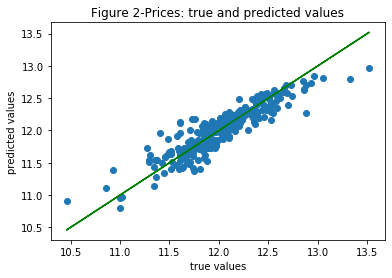

Mean absolute error of the prediction is: 0.1255263492080381
Mean squared error of the prediction is: 0.028061234942725548
Root mean squared error of the prediction is: 0.16751487976512877
Mean absolute percentage error of the prediction is: 1.048180295543415


In [24]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Figure 2-Prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))